# Lab 12 - Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data ZIP file from [here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and place it under the current directory. 

After that, let’s import some necessities.

In [1]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/MyDrive/Colab Notebooks/NN&NLP/lab12_cornell movie-dialogs corpus")

Mounted at /content/drive


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [3]:
#Loading the data
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [4]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [5]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [6]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [7]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [8]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [9]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [10]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [11]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings

        #  pass the embedding into a bidirectional version of the GRU
        #                                                                                        
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions

        self.Bidirectional1 = Bidirectional(GRU(self.enc_units, return_state= False, return_sequences= True, recurrent_initializer = 'glorot_uniform'))
        self.Bidirectional2 = Bidirectional(GRU(self.enc_units, return_state= True, return_sequences= True, recurrent_initializer = 'glorot_uniform'))
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):

        x = self.embeddings(x)
        x = self.dropout(x) # dropout 1
        x = self.Bidirectional1(x)
        x = self.dropout(x) # dropout 2
        x = self.Bidirectional2(x)
        output, state_f,state_b = x

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))



<font color = "#8c9096"><b>Here we just created two Bidirectional layers in which we have passed the GRU layer. The encoding units that were passed to the function are passed as parameters to the GRU layer.</b></font>

In [13]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        self.dropout = Dropout(0.2)
        # Create the decoder with attention

        self.attention = BahdanauAttention(self.units)

        self.decoder_gru_l1 = Bidirectional(GRU(self.units, return_sequences=True, return_state=False, recurrent_initializer = 'glorot_uniform'))
        self.decoder_gru_l2 = (GRU(self.units, return_sequences=False, return_state=True, recurrent_initializer = 'glorot_uniform'))


    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        x = self.decoder_gru_l2(x)
        output, state = x
        x = self.fc(output)
        return x, state, attention_weights

<font color = "#8c9096"><b>Here we created a bidirectional layer in which we pass the GRU layer as we did for the encoder. Finally we created a standalone GRU layer with the units defined as the parameter.</b></font>

In [16]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [17]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [18]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [19]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [20]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [25]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [26]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

In [30]:
checkpoint.restore(str(emb_dim)+"-ckpt-60")# last save 60
current_ep = 60

Epoch 60 Batch 598 Loss: 1.4146
Epoch 60 Batch 1196 Loss: 1.6220
Epoch 60 Batch 1794 Loss: 1.5663
Epoch 60 Batch 2392 Loss: 1.6470
Epoch 60 Batch 2990 Loss: 1.4012
Epoch 60 Batch 3588 Loss: 1.3630

*** Epoch 60 Loss 1.4680 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: it is a good time 
%
Greedy| Q: Do you want to go out ?  A: i am not here 
####################
check point saved!


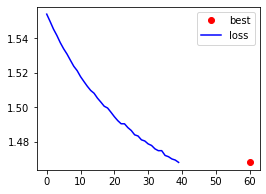

Best epoch so far:  60
Time  218.281 sec

Epoch 61 Batch 598 Loss: 1.4072
Epoch 61 Batch 1196 Loss: 1.7739
Epoch 61 Batch 1794 Loss: 1.8481
Epoch 61 Batch 2392 Loss: 1.9028
Epoch 61 Batch 2990 Loss: 1.4256
Epoch 61 Batch 3588 Loss: 1.7079

*** Epoch 61 Loss 1.4661 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to be a sin 
%
Greedy| Q: What is your favorite restaurant ?  A: a little player 
%
Greedy| Q: Do you want to go out ?  A: i am not sure i am not a little 
####################
check point saved!
Best epoch so far:  61
Time  216.254 sec

Epoch 62 Batch 598 Loss: 1.3878
Epoch 62 Batch 1196 Loss: 1.9751
Epoch 62 Batch 1794 Loss: 1.8452
Epoch 62 Batch 2392 Loss: 1.9018
Epoch 62 Batch 2990 Loss: 1.5016
Epoch 62 Batch 3588 Loss: 1.9022

*** Epoch 62 Loss 1.4658 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doi

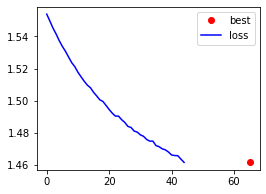

Best epoch so far:  65
Time  216.951 sec

Epoch 66 Batch 598 Loss: 1.4273
Epoch 66 Batch 1196 Loss: 1.7463
Epoch 66 Batch 1794 Loss: 1.8370
Epoch 66 Batch 2392 Loss: 1.8962
Epoch 66 Batch 2990 Loss: 1.3293
Epoch 66 Batch 3588 Loss: 1.6765

*** Epoch 66 Loss 1.4627 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to be a crack 
%
Greedy| Q: What is your favorite restaurant ?  A: a little of the river 
%
Greedy| Q: Do you want to go out ?  A: i am not a messenger 
####################
Best epoch so far:  65
Time  217.161 sec

Epoch 67 Batch 598 Loss: 1.4042
Epoch 67 Batch 1196 Loss: 1.9032
Epoch 67 Batch 1794 Loss: 1.8275
Epoch 67 Batch 2392 Loss: 1.8751
Epoch 67 Batch 2990 Loss: 1.5192
Epoch 67 Batch 3588 Loss: 1.7691

*** Epoch 67 Loss 1.4606 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to be 

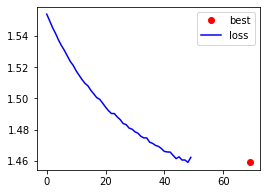

Best epoch so far:  69
Time  217.805 sec

Epoch 71 Batch 598 Loss: 1.4540
Epoch 71 Batch 1196 Loss: 1.7088
Epoch 71 Batch 1794 Loss: 1.7429
Epoch 71 Batch 2392 Loss: 1.8932
Epoch 71 Batch 2990 Loss: 1.2941
Epoch 71 Batch 3588 Loss: 1.5928

*** Epoch 71 Loss 1.4571 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: it is a good time to be acquainted 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  71
Time  217.720 sec

Epoch 72 Batch 598 Loss: 1.3838
Epoch 72 Batch 1196 Loss: 1.8388
Epoch 72 Batch 1794 Loss: 1.8172
Epoch 72 Batch 2392 Loss: 1.8971
Epoch 72 Batch 2990 Loss: 1.5195
Epoch 72 Batch 3588 Loss: 1.7480

*** Epoch 72 Loss 1.4556 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am no

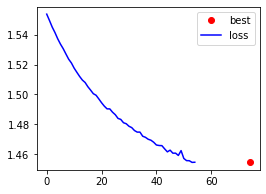

Best epoch so far:  74
Time  217.080 sec

Epoch 76 Batch 598 Loss: 1.3963
Epoch 76 Batch 1196 Loss: 1.5801
Epoch 76 Batch 1794 Loss: 1.5560
Epoch 76 Batch 2392 Loss: 1.6552
Epoch 76 Batch 2990 Loss: 1.3959
Epoch 76 Batch 3588 Loss: 1.3316

*** Epoch 76 Loss 1.4533 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: it is a good time 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  76
Time  217.447 sec

Epoch 77 Batch 598 Loss: 1.3941
Epoch 77 Batch 1196 Loss: 1.7291
Epoch 77 Batch 1794 Loss: 1.8256
Epoch 77 Batch 2392 Loss: 1.9150
Epoch 77 Batch 2990 Loss: 1.4300
Epoch 77 Batch 3588 Loss: 1.6995

*** Epoch 77 Loss 1.4525 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%


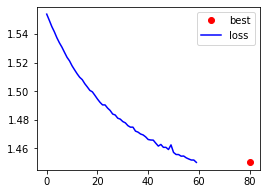

Best epoch so far:  80
Time  211.381 sec

Epoch 81 Batch 598 Loss: 1.3383
Epoch 81 Batch 1196 Loss: 1.6030
Epoch 81 Batch 1794 Loss: 1.5033
Epoch 81 Batch 2392 Loss: 1.6634
Epoch 81 Batch 2990 Loss: 1.3404
Epoch 81 Batch 3588 Loss: 1.4162

*** Epoch 81 Loss 1.4488 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What is your favorite restaurant ?  A: a little of the river 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  81
Time  210.760 sec

Epoch 82 Batch 598 Loss: 1.4312
Epoch 82 Batch 1196 Loss: 1.7246
Epoch 82 Batch 1794 Loss: 1.7989
Epoch 82 Batch 2392 Loss: 1.8885
Epoch 82 Batch 2990 Loss: 1.3302
Epoch 82 Batch 3588 Loss: 1.6523

*** Epoch 82 Loss 1.4487 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not go

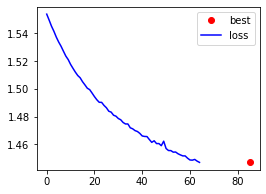

Best epoch so far:  85
Time  216.475 sec

Epoch 86 Batch 598 Loss: 1.3779
Epoch 86 Batch 1196 Loss: 1.6658
Epoch 86 Batch 1794 Loss: 1.4724
Epoch 86 Batch 2392 Loss: 1.7121
Epoch 86 Batch 2990 Loss: 1.3708
Epoch 86 Batch 3588 Loss: 1.4837

*** Epoch 86 Loss 1.4474 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a dozen 
%
Greedy| Q: What is your favorite restaurant ?  A: it is not a wrong number 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  85
Time  213.645 sec

Epoch 87 Batch 598 Loss: 1.4289
Epoch 87 Batch 1196 Loss: 1.7064
Epoch 87 Batch 1794 Loss: 1.7028
Epoch 87 Batch 2392 Loss: 1.8973
Epoch 87 Batch 2990 Loss: 1.2631
Epoch 87 Batch 3588 Loss: 1.5955

*** Epoch 87 Loss 1.4456 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What

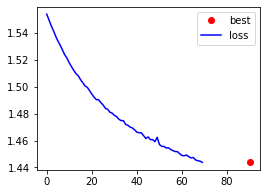

Best epoch so far:  90
Time  211.689 sec

Epoch 91 Batch 598 Loss: 1.3017
Epoch 91 Batch 1196 Loss: 1.7011
Epoch 91 Batch 1794 Loss: 1.4976
Epoch 91 Batch 2392 Loss: 1.7478
Epoch 91 Batch 2990 Loss: 1.4068
Epoch 91 Batch 3588 Loss: 1.5032

*** Epoch 91 Loss 1.4437 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: a lot of days 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  91
Time  214.659 sec

Epoch 92 Batch 598 Loss: 1.3650
Epoch 92 Batch 1196 Loss: 1.5740
Epoch 92 Batch 1794 Loss: 1.5250
Epoch 92 Batch 2392 Loss: 1.6541
Epoch 92 Batch 2990 Loss: 1.3818
Epoch 92 Batch 3588 Loss: 1.3206

*** Epoch 92 Loss 1.4441 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| 

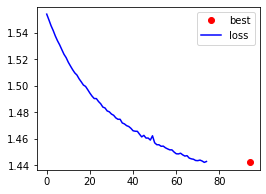

Best epoch so far:  94
Time  214.366 sec

Epoch 96 Batch 598 Loss: 1.2819
Epoch 96 Batch 1196 Loss: 1.7693
Epoch 96 Batch 1794 Loss: 1.6204
Epoch 96 Batch 2392 Loss: 1.7583
Epoch 96 Batch 2990 Loss: 1.4718
Epoch 96 Batch 3588 Loss: 1.6051

*** Epoch 96 Loss 1.4413 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: remark 
%
Greedy| Q: Do you want to go out ?  A: i am not here 
####################
check point saved!
Best epoch so far:  96
Time  211.713 sec

Epoch 97 Batch 598 Loss: 1.3312
Epoch 97 Batch 1196 Loss: 1.6037
Epoch 97 Batch 1794 Loss: 1.4962
Epoch 97 Batch 2392 Loss: 1.6576
Epoch 97 Batch 2990 Loss: 1.3231
Epoch 97 Batch 3588 Loss: 1.3912

*** Epoch 97 Loss 1.4417 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Gre

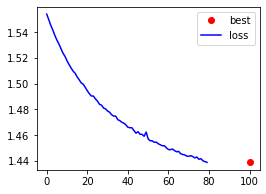

Best epoch so far:  100
Time  211.901 sec

Epoch 101 Batch 598 Loss: 1.3200
Epoch 101 Batch 1196 Loss: 1.8135
Epoch 101 Batch 1794 Loss: 1.7406
Epoch 101 Batch 2392 Loss: 1.6733
Epoch 101 Batch 2990 Loss: 1.4891
Epoch 101 Batch 3588 Loss: 1.6803

*** Epoch 101 Loss 1.4376 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: remark 
%
Greedy| Q: Do you want to go out ?  A: i am not a lesbian 
####################
check point saved!
Best epoch so far:  101
Time  211.903 sec

Epoch 102 Batch 598 Loss: 1.3753
Epoch 102 Batch 1196 Loss: 1.6379
Epoch 102 Batch 1794 Loss: 1.4719
Epoch 102 Batch 2392 Loss: 1.6870
Epoch 102 Batch 2990 Loss: 1.3830
Epoch 102 Batch 3588 Loss: 1.4758

*** Epoch 102 Loss 1.4382 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am no

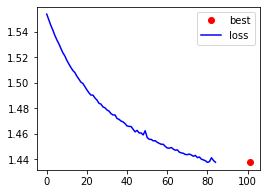

Best epoch so far:  101
Time  214.448 sec

Epoch 106 Batch 598 Loss: 1.2122
Epoch 106 Batch 1196 Loss: 1.9762
Epoch 106 Batch 1794 Loss: 1.7179
Epoch 106 Batch 2392 Loss: 1.7715
Epoch 106 Batch 2990 Loss: 1.4745
Epoch 106 Batch 3588 Loss: 1.6998

*** Epoch 106 Loss 1.4371 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: it is not a witch 
%
Greedy| Q: Do you want to go out ?  A: i am not a lesbian 
####################
check point saved!
Best epoch so far:  106
Time  212.125 sec

Epoch 107 Batch 598 Loss: 1.3033
Epoch 107 Batch 1196 Loss: 1.7358
Epoch 107 Batch 1794 Loss: 1.4845
Epoch 107 Batch 2392 Loss: 1.7299
Epoch 107 Batch 2990 Loss: 1.3987
Epoch 107 Batch 3588 Loss: 1.4748

*** Epoch 107 Loss 1.4367 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ? 

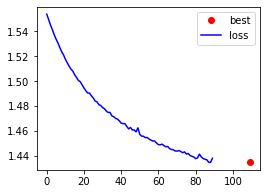

Best epoch so far:  109
Time  212.050 sec

Epoch 111 Batch 598 Loss: 1.2513
Epoch 111 Batch 1196 Loss: 1.9853
Epoch 111 Batch 1794 Loss: 1.7029
Epoch 111 Batch 2392 Loss: 1.7846
Epoch 111 Batch 2990 Loss: 1.5142
Epoch 111 Batch 3588 Loss: 1.6788

*** Epoch 111 Loss 1.4373 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: a little oldfashioned 
%
Greedy| Q: Do you want to go out ?  A: i am not a little 
####################
Best epoch so far:  109
Time  212.161 sec

Epoch 112 Batch 598 Loss: 1.2933
Epoch 112 Batch 1196 Loss: 1.7664
Epoch 112 Batch 1794 Loss: 1.6152
Epoch 112 Batch 2392 Loss: 1.7515
Epoch 112 Batch 2990 Loss: 1.4421
Epoch 112 Batch 3588 Loss: 1.5910

*** Epoch 112 Loss 1.4391 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not go

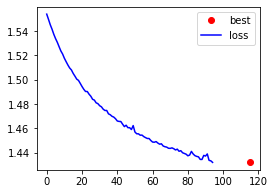

Best epoch so far:  115
Time  212.261 sec

Epoch 116 Batch 598 Loss: 1.3058
Epoch 116 Batch 1196 Loss: 1.9387
Epoch 116 Batch 1794 Loss: 1.8782
Epoch 116 Batch 2392 Loss: 1.7773
Epoch 116 Batch 2990 Loss: 1.5023
Epoch 116 Batch 3588 Loss: 1.7011

*** Epoch 116 Loss 1.4332 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: helluva noise miz wilkes 
%
Greedy| Q: Do you want to go out ?  A: i am not a peach 
####################
Best epoch so far:  115
Time  211.992 sec

Epoch 117 Batch 598 Loss: 1.3133
Epoch 117 Batch 1196 Loss: 1.8276
Epoch 117 Batch 1794 Loss: 1.7364
Epoch 117 Batch 2392 Loss: 1.6743
Epoch 117 Batch 2990 Loss: 1.4842
Epoch 117 Batch 3588 Loss: 1.6979

*** Epoch 117 Loss 1.4334 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not going to 

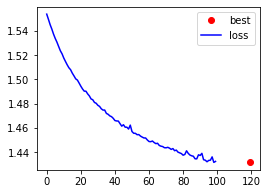

Best epoch so far:  119
Time  213.420 sec

Epoch 121 Batch 598 Loss: 1.3665
Epoch 121 Batch 1196 Loss: 1.8408
Epoch 121 Batch 1794 Loss: 1.8023
Epoch 121 Batch 2392 Loss: 1.7608
Epoch 121 Batch 2990 Loss: 1.4374
Epoch 121 Batch 3588 Loss: 1.7592

*** Epoch 121 Loss 1.4353 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: the president 
%
Greedy| Q: Do you want to go out ?  A: i am not a very good time 
####################
Best epoch so far:  119
Time  212.714 sec

Epoch 122 Batch 598 Loss: 1.1933
Epoch 122 Batch 1196 Loss: 1.9331
Epoch 122 Batch 1794 Loss: 1.6968
Epoch 122 Batch 2392 Loss: 1.7822
Epoch 122 Batch 2990 Loss: 1.4627
Epoch 122 Batch 3588 Loss: 1.7224

*** Epoch 122 Loss 1.4308 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going t

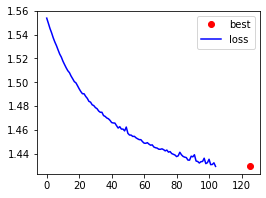

Best epoch so far:  125
Time  212.309 sec

Epoch 126 Batch 598 Loss: 1.3731
Epoch 126 Batch 1196 Loss: 1.8755
Epoch 126 Batch 1794 Loss: 1.8182
Epoch 126 Batch 2392 Loss: 1.8810
Epoch 126 Batch 2990 Loss: 1.4424
Epoch 126 Batch 3588 Loss: 1.8660

*** Epoch 126 Loss 1.4313 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: a lot of rome 
%
Greedy| Q: Do you want to go out ?  A: i am not a little 
####################
Best epoch so far:  125
Time  211.789 sec

Epoch 127 Batch 598 Loss: 1.2506
Epoch 127 Batch 1196 Loss: 1.9745
Epoch 127 Batch 1794 Loss: 1.7154
Epoch 127 Batch 2392 Loss: 1.7932
Epoch 127 Batch 2990 Loss: 1.4812
Epoch 127 Batch 3588 Loss: 1.6782

*** Epoch 127 Loss 1.4302 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy

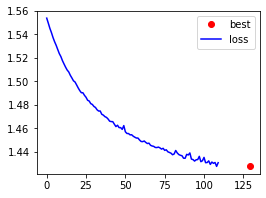

Best epoch so far:  129
Time  211.854 sec

Epoch 131 Batch 598 Loss: 1.4121
Epoch 131 Batch 1196 Loss: 1.8444
Epoch 131 Batch 1794 Loss: 1.7807
Epoch 131 Batch 2392 Loss: 1.8684
Epoch 131 Batch 2990 Loss: 1.4684
Epoch 131 Batch 3588 Loss: 1.7336

*** Epoch 131 Loss 1.4297 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: a little oldfashioned 
%
Greedy| Q: Do you want to go out ?  A: i am not a little late 
####################
Best epoch so far:  129
Time  212.210 sec

Epoch 132 Batch 598 Loss: 1.2942
Epoch 132 Batch 1196 Loss: 1.9147
Epoch 132 Batch 1794 Loss: 1.8738
Epoch 132 Batch 2392 Loss: 1.7921
Epoch 132 Batch 2990 Loss: 1.5026
Epoch 132 Batch 3588 Loss: 1.6908

*** Epoch 132 Loss 1.4285 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to work on 
%
Greedy| Q: What are you do

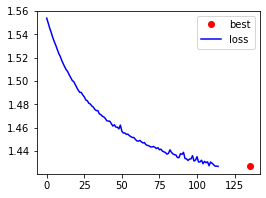

Best epoch so far:  135
Time  225.548 sec

Epoch 136 Batch 598 Loss: 1.3856
Epoch 136 Batch 1196 Loss: 1.7738
Epoch 136 Batch 1794 Loss: 1.7627
Epoch 136 Batch 2392 Loss: 1.8692
Epoch 136 Batch 2990 Loss: 1.4663
Epoch 136 Batch 3588 Loss: 1.7359

*** Epoch 136 Loss 1.4263 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: turkish 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  136
Time  225.196 sec

Epoch 137 Batch 598 Loss: 1.3655
Epoch 137 Batch 1196 Loss: 1.8493
Epoch 137 Batch 1794 Loss: 1.8108
Epoch 137 Batch 2392 Loss: 1.7601
Epoch 137 Batch 2990 Loss: 1.4511
Epoch 137 Batch 3588 Loss: 1.7438

*** Epoch 137 Loss 1.4267 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy|

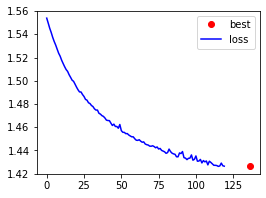

Best epoch so far:  136
Time  210.616 sec

Epoch 141 Batch 598 Loss: 1.3723
Epoch 141 Batch 1196 Loss: 1.6777
Epoch 141 Batch 1794 Loss: 1.7827
Epoch 141 Batch 2392 Loss: 1.8792
Epoch 141 Batch 2990 Loss: 1.4084
Epoch 141 Batch 3588 Loss: 1.6715

*** Epoch 141 Loss 1.4257 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am sorry i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: the traffic is he 
%
Greedy| Q: Do you want to go out ?  A: i am not a little 
####################
check point saved!
Best epoch so far:  141
Time  212.993 sec

Epoch 142 Batch 598 Loss: 1.3542
Epoch 142 Batch 1196 Loss: 1.8867
Epoch 142 Batch 1794 Loss: 1.8246
Epoch 142 Batch 2392 Loss: 1.8964
Epoch 142 Batch 2990 Loss: 1.4422
Epoch 142 Batch 3588 Loss: 1.8537

*** Epoch 142 Loss 1.4273 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are 

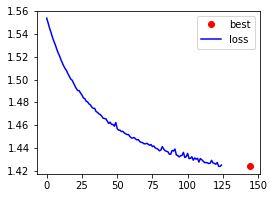

Best epoch so far:  144
Time  209.712 sec

Epoch 146 Batch 598 Loss: 1.4157
Epoch 146 Batch 1196 Loss: 1.6434
Epoch 146 Batch 1794 Loss: 1.7515
Epoch 146 Batch 2392 Loss: 1.8821
Epoch 146 Batch 2990 Loss: 1.2837
Epoch 146 Batch 3588 Loss: 1.6390

*** Epoch 146 Loss 1.4257 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: the statue of rome 
%
Greedy| Q: Do you want to go out ?  A: i am not sleepy 
####################
Best epoch so far:  144
Time  210.456 sec

Epoch 147 Batch 598 Loss: 1.3892
Epoch 147 Batch 1196 Loss: 1.8248
Epoch 147 Batch 1794 Loss: 1.7819
Epoch 147 Batch 2392 Loss: 1.8792
Epoch 147 Batch 2990 Loss: 1.4574
Epoch 147 Batch 3588 Loss: 1.7311

*** Epoch 147 Loss 1.4268 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am going to be a sin 
%
Greedy| Q: What are you doing ?  A: i am go

In [31]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [32]:
checkpoint.restore(str(emb_dim)+"-ckpt-150")


In [33]:
test_bot()


####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am sorry i am jogging 
%
Greedy| Q: What is your favorite restaurant ?  A: the man 
%
Greedy| Q: Do you want to go out ?  A: i am not a huge fan 
####################


Input: how old are you
Predicted answer: thirtyfive 


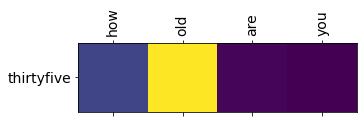

In [34]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: no 


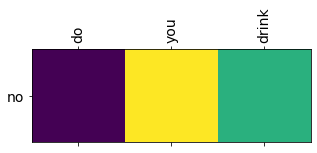

In [35]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.

### **For Epoch 5:**<br>
Epoch 5 Batch 598 Loss: 1.4375<br>
Epoch 5 Batch 1196 Loss: 2.1154<br>
Epoch 5 Batch 1794 Loss: 1.8994<br>
Epoch 5 Batch 2392 Loss: 2.0242<br>
Epoch 5 Batch 2990 Loss: 1.7987<br>
Epoch 5 Batch 3588 Loss: 2.1512<br>

*** Epoch 5 Loss 1.7229 ***<br>

####################<br>
Greedy| Q: Hello   A: hi <br>
%<br>
Greedy| Q: How are you ?  A: i am not going to be a good idea <br>
%<br>
Greedy| Q: What are you doing ?  A: i am not going to be a good idea <br>
%<br>
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be <br>a good idea <br>
%<br>
Greedy| Q: Do you want to go out ?  A: i am not going to be a good idea <br>
####################<br>
check point saved!<br>
 
Best epoch so far:  5<br>
Time  284.578 sec<br>
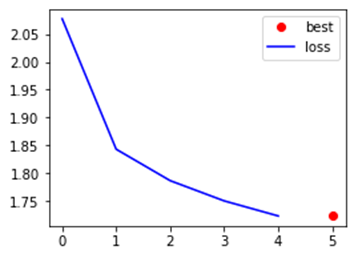


### **For Epoch 50 (Restored from 10th checkpoint):**<br>
Epoch 40 Batch 598 Loss: 1.4074<br>
Epoch 40 Batch 1196 Loss: 1.9637<br>
Epoch 40 Batch 1794 Loss: 1.9027<br>
Epoch 40 Batch 2392 Loss: 1.9566<br>
Epoch 40 Batch 2990 Loss: 1.5281<br>
Epoch 40 Batch 3588 Loss: 1.8910<br>

*** Epoch 40 Loss 1.5022 ***<br>

####################<br>
Greedy| Q: Hello   A: hello <br>
%<br>
Greedy| Q: How are you ?  A: i am not a seizure <br>
%<br>
Greedy| Q: What are you doing ?  A: i am not a seizure <br>
%<br>
Greedy| Q: What is your favorite restaurant ?  A: i am not sure <br>
%<br>
Greedy| Q: Do you want to go out ?  A: no <br>
####################<br>
check point saved!<br>
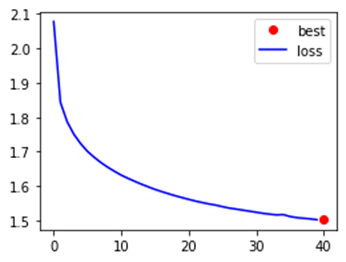
 


### **For Epoch 140 (Restored from 83rd checkpoint)**:
Epoch 57 Batch 598 Loss: 1.2956<br>
Epoch 57 Batch 1196 Loss: 1.8414<br>
Epoch 57 Batch 1794 Loss: 1.8710<br>
Epoch 57 Batch 2392 Loss: 1.7296<br>
Epoch 57 Batch 2990 Loss: 1.4834<br>
Epoch 57 Batch 3588 Loss: 1.6756<br>

*** Epoch 57 Loss 1.4312 ***<br>

####################<br>
Greedy| Q: Hello   A: hello <br>
%<br>
Greedy| Q: How are you ?  A: i am not going to do <br>
%<br>
Greedy| Q: What are you doing ?  A: i am not sure <br>
%<br>
Greedy| Q: What is your favorite restaurant ?  A: shhhh <br>
%<br>
Greedy| Q: Do you want to go out ?  A: i am not going to do <br>
####################<br>
Best epoch so far:  56<br>
Time  468.751 sec<br>



In [36]:
qs = ['hello', 'how are you', 'what are you doing', 'what is your favourite restaurant', 'where do you like to eat', 'do you want to go out',
'what do you want to eat', 'do you drink', 'are you okay', 'when are you coming']

Input: hello
Predicted answer: hello 


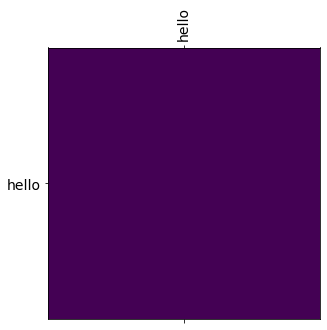

Input: how are you
Predicted answer: i am not going to do 


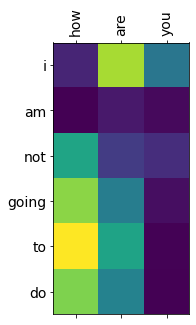

Input: what are you doing
Predicted answer: i am not going to do 


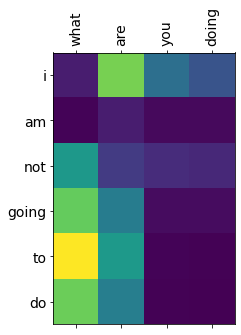

Input: what is your favourite restaurant
Predicted answer: i am not going to do 


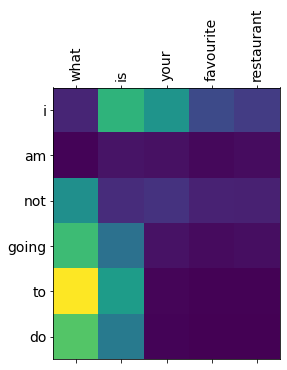

Input: where do you like to eat
Predicted answer: i am not going to do 


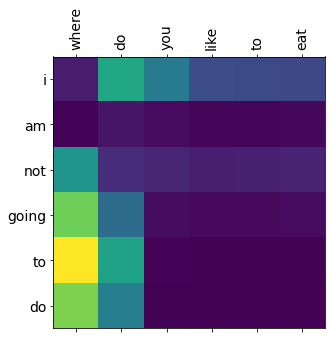

Input: do you want to go out
Predicted answer: i am not going to do 


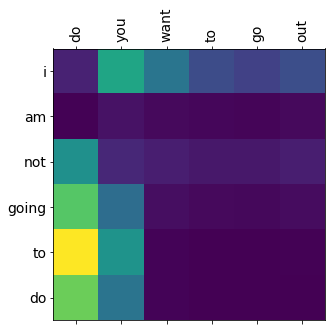

Input: what do you want to eat
Predicted answer: i am not going to do 


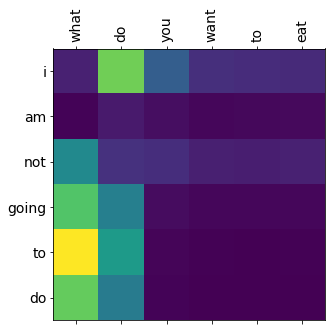

Input: do you drink
Predicted answer: i am not going to do 


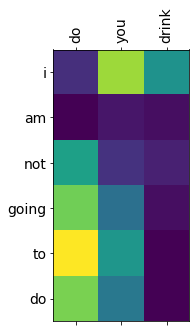

Input: are you okay
Predicted answer: i am not going to do 


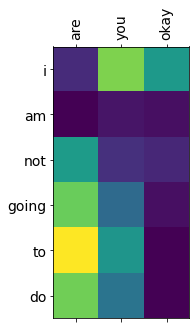

Input: when are you coming
Predicted answer: i am not going to do 


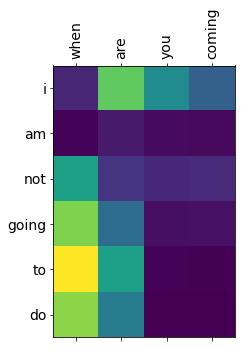

In [38]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")
for q in qs:
    answer(q, training=False)

Input: hello
Predicted answer: hello 


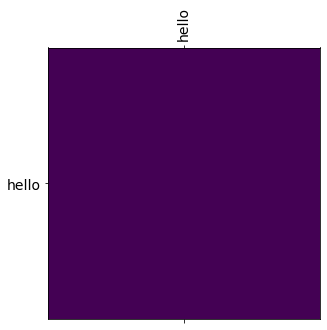

Input: how are you
Predicted answer: i am here 


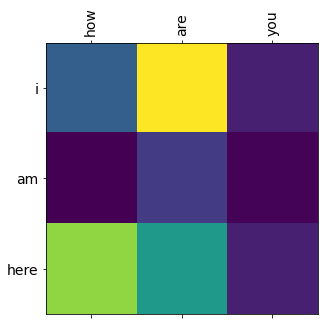

Input: what are you doing
Predicted answer: i am not going to be a good time 


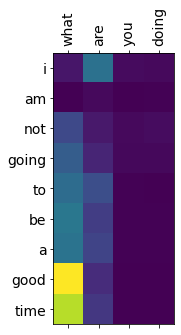

Input: what is your favourite restaurant
Predicted answer: four years ago 


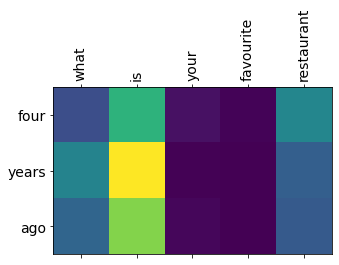

Input: where do you like to eat
Predicted answer: i am not sure i am not sure i am not sure i am not sure i am 


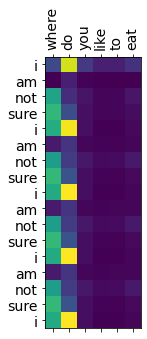

Input: do you want to go out
Predicted answer: no 


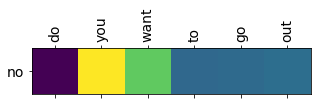

Input: what do you want to eat
Predicted answer: i am a dentist 


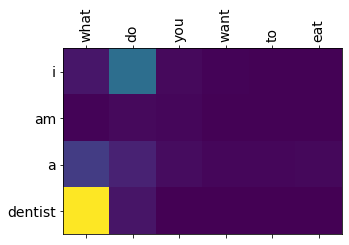

Input: do you drink
Predicted answer: no 


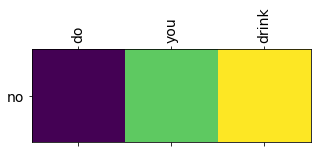

Input: are you okay
Predicted answer: i am fine 


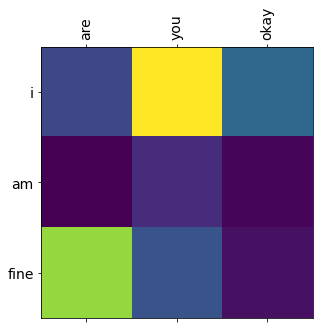

Input: when are you coming
Predicted answer: i am going to do 


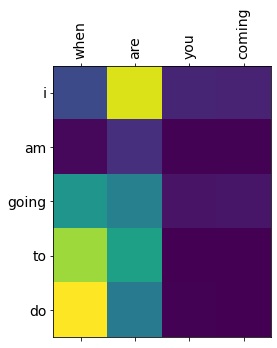

In [39]:
checkpoint.restore(str(emb_dim)+"-ckpt-50")
for q in qs:
    answer(q, training=False)

Input: hello
Predicted answer: hello 


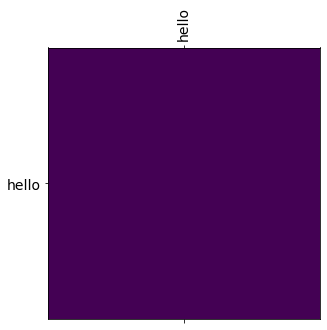

Input: how are you
Predicted answer: i am not 


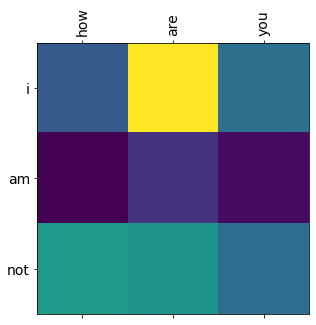

Input: what are you doing
Predicted answer: i am sorry i am going to do 


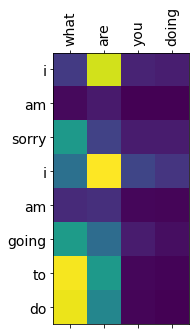

Input: what is your favourite restaurant
Predicted answer: a witch 


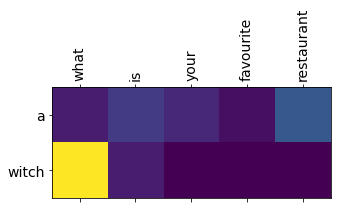

Input: where do you like to eat
Predicted answer: i do not know 


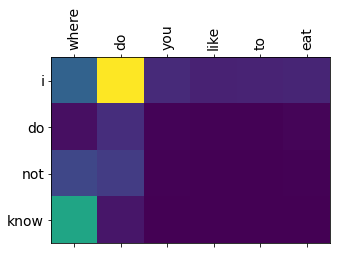

Input: do you want to go out
Predicted answer: i am not a faggot 


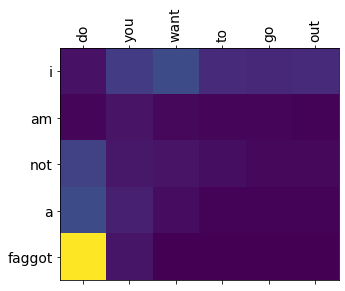

Input: what do you want to eat
Predicted answer: i am not going to do 


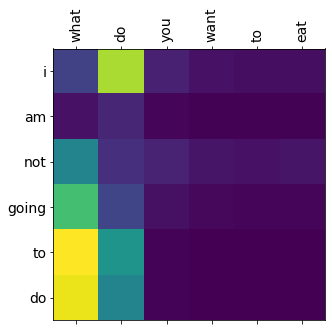

Input: do you drink
Predicted answer: no 


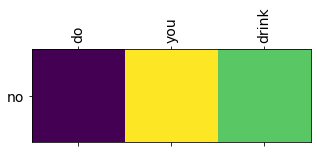

Input: are you okay
Predicted answer: i am fine 


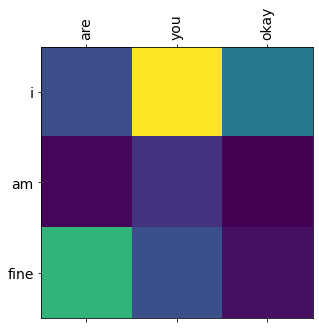

Input: when are you coming
Predicted answer: i am not 


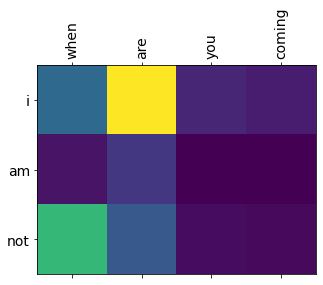

In [40]:
checkpoint.restore(str(emb_dim)+"-ckpt-140")
for q in qs:
    answer(q, training=False)

## Did the models learn to track local relations between words? 
Yes the models do learn to track local relation between words. If we consider the question 'What do you want to eat', the matrix shows increased correlation between words of the question and the answer as well as in the question and answer itself.

## Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?
Yes the model did attend to the least frequent tokens in the utterance. If you consider the question 'what is your favourite restaurant', there was considerable difference in the output to this question. However, we can see that no answer is relevant to the question and the model is giving random answers to the question. This shows signs of overfitting.

## Did the models learn to track some major syntactic relations in the utterances (subject-verb, verb-object)?
Yes it was able to track the syntactic relations correctly.
Even if it did struggle even in the 140th epoch where it says 'i am not sure you are not' which is grammactically incorrect, it was able to get the Noun - verb - object concatenated structures correctly as well.

## Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?
They were indeed able to capture various linguistic features like Tense. It is able to detect the present tense and answer in the appropriate sense. They are also able to detect the POS Tags like for eg in the response 'i am seventyfour' it correctly identified the structure of Subject - Verb - Object.

## What is the effect of more training on the length of responss?
The training did not really affect the length of responses. Sometimes the length got less and then got more again and vice versa. So the length of the response is not related to the epochs.

## In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?
We can experiment with the usage of other algorithms like CNN or LSTM to make the pipeline better. Sutskever et al., 2014; Bahdanau et al., 2014; Luong et al., 2015 suggest the usage of Neural generative models which are able to map dialogue history directly into
the response in current turn, while requires a minimum amount of hand-crafting.

You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.